In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hdu = fits.open('ktwo200008664-c05_0256.fits')
hdu = fits.open('ktwo200062544-c07_0256.fits')
#hdu = fits.open('ktwo200062534-c07_0256.fits')

In [3]:
image = hdu[1].data['FLUX']
image.shape

(1, 51, 51)

In [4]:
image = image.reshape(image.shape[1:])
sigma_psf=0.5

In [5]:
np.median(image), np.max(image), np.std(image)

(39.186134, 196908.47, 6767.3496)

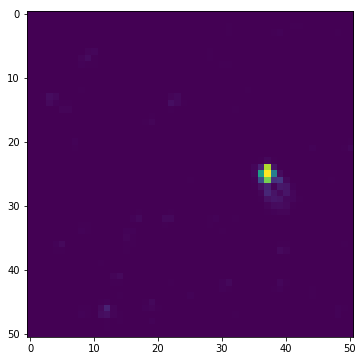

In [6]:
plt.figure(figsize=(6,6))
plt.imshow(image)

In [812]:
from astropy.table import Table
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
sigma_psf = 1.
sources = Table()
sources['flux'] = [43000, 30000, 15000, 13000]
sources['x_mean'] = [12, 17, 12, 17]
sources['y_mean'] = [15, 15, 20, 20]
sources['x_stddev'] = sigma_psf*np.ones(4)
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0, 0, 0, 0]
sources['id'] = [1, 2, 3, 4]
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources) +
         make_noise_image(tshape, type='poisson', mean=4.,
                          random_state=1) +
         make_noise_image(tshape, type='gaussian', mean=0.,
                          stddev=166, random_state=1))

## Go-go PSF photometry!

In [818]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

[IRAFStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.IRAFStarFinder.html#photutils.detection.IRAFStarFinder)

In [819]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=5*std,
                          fwhm=2*sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=8., brightest=2)
#from photutils import DAOStarFinder
#daofind = DAOStarFinder(fwhm=5., threshold=3.*bkg_sigma, roundhi=5., ratio=.85) 

In [820]:
sources = iraffind(image)
from photutils import aperture_photometry, CircularAperture

positions = (sources['xcentroid'], sources['ycentroid'])    
apertures = CircularAperture(positions, r=4.)      
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray_r', origin='lower')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,30.43942569686055,26.881082880046275,1.4707520367716103,0.6245708838240674,0.09886298264986154,144.3562595302867,12,2940.4479166666665,197101.390625,570604.6110839844,-14.390838192225877
2,49.5104909002944,46.352460336585914,1.2920269751530842,0.5486733382788506,0.18669230753427357,124.15064784281864,8,1399.9417317708333,121804.484375,344660.41943359375,-13.843478530476895


In [822]:
daogroup = DAOGroup(2.*sigma_psf*gaussian_sigma_to_fwhm)

In [823]:
bkg = MMMBackground()
# from astropy.stats import SigmaClip
# from photutils import MedianBackground
# sigma_clip = SigmaClip(sigma=sigma_psf)
# bkg = MedianBackground(sigma_clip)

In [824]:
fitter = LevMarLSQFitter()
#fitter =  LinearLSQFitter()

In [825]:
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)


In [826]:
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=10, fitshape=5)
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

(0, 49)

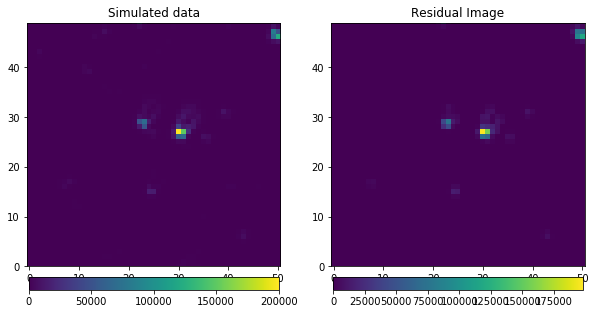

In [828]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1,)

plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',)
plt.ylim(0,49)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(image-residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.ylim(0,49)


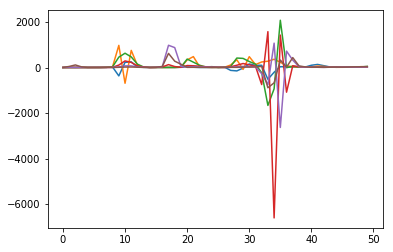

In [783]:
for i in range(42,48):
    plt.plot(residual_image[i,:])

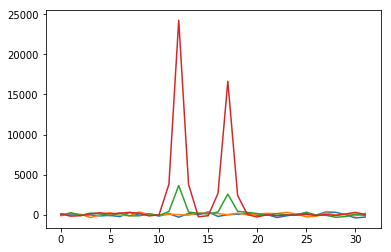

In [496]:
for i in range(12,16):
    plt.plot(residual_image[i,:])